Things to cover in this section:

✔️ Train, tune and use time series, sequence and prediction models.  
✔️ Prepare data for time series learning.  
✔️ Understand Mean Average Error (MAE) and how it can be used to evaluate accuracy of sequence models.  
  Use RNNs and CNNs for time series, sequence and forecasting models.  
✔️ Identify when to use trailing versus centred windows.  
  Use TensorFlow for forecasting.  
✔️ Prepare features and labels.  
  Identify and compensate for sequence bias.  
  Adjust the learning rate dynamically in time series, sequence and prediction models.  

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from dateutil.relativedelta import *
import datetime

import tensorflow as tf

from pathlib import Path
import os

## Explore Inputs and Outputs
wit a simple Syntetic Data

In [14]:
dataset = tf.data.Dataset.range(12)

dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))

dataset = dataset.shuffle(buffer_size=10)
dataset = dataset.batch(2).prefetch(1)

for x, y in dataset:
    print('x = ', x.numpy())
    print('y = ', y.numpy())

x =  [[6 7 8 9]
 [3 4 5 6]]
y =  [[10]
 [ 7]]
x =  [[ 5  6  7  8]
 [ 7  8  9 10]]
y =  [[ 9]
 [11]]
x =  [[1 2 3 4]
 [2 3 4 5]]
y =  [[5]
 [6]]
x =  [[0 1 2 3]
 [4 5 6 7]]
y =  [[4]
 [8]]


In [2]:
# run once
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## Prepare data for time series learning  

In [4]:
home = str(Path.home())
base_dir = os.path.join(home, 'datasets/')
data_dir = os.path.join(base_dir, 'sunspot.csv')
sunspots = pd.read_csv(data_dir)
series = np.array(sunspots.x.to_list())

In [5]:
date_str = '1749-01-01' # Start date
format_str = '%Y-%m-%d' # The format
start_date = datetime.datetime.strptime(date_str, format_str)

In [6]:
dates = [start_date+relativedelta(months=+i) for i in range(3177)]
time = [i for i in range(3177)]

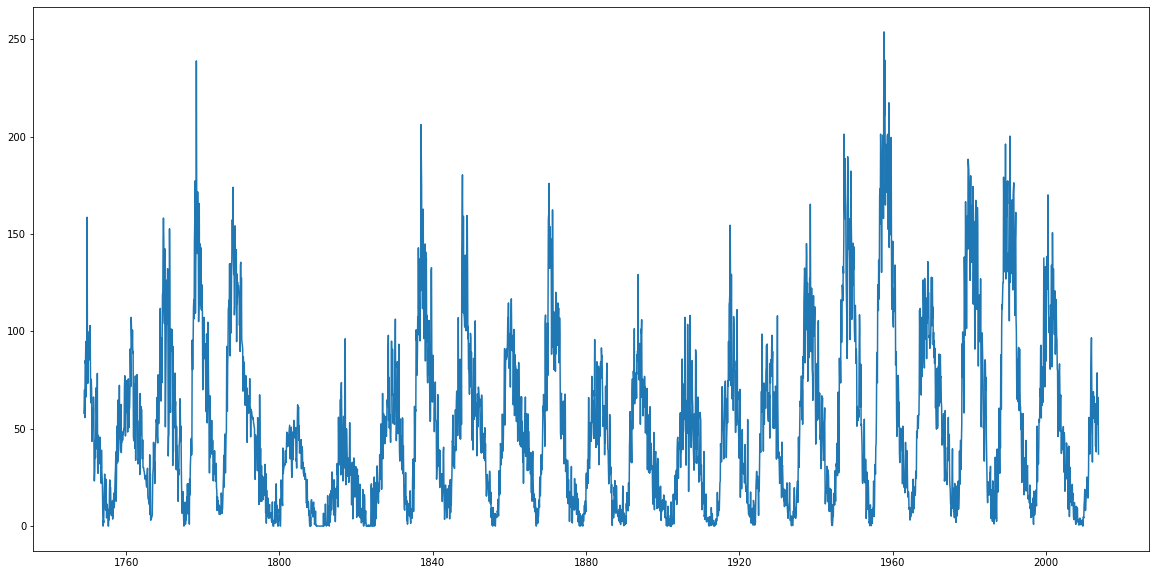

In [7]:
plt.figure(figsize=(20,10))
plt.plot(dates, series)

## Prepare features and labels.  

In [8]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [10]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

## Scheduling Learning Rate

In [19]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", activation="relu", input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule], verbose = 0)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)


[1e-08, 0.0001, 0, 60]

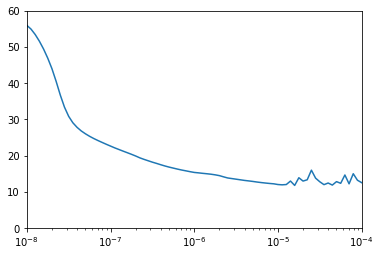

In [20]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])